# California housing prices predictor #
Analysis of the *California Housing Prices dataset* from the StatLib repository.

This dataset is based on data from the 1990 California centsus.

The goal of this excercise is to build a predictor for housing prices in California.

## Data Cleaning ##

In [3]:
#
# Functioan that downloads housing dataset tarfile and extracts it to specified directory
#

import os
import tarfile
from six.moves import urllib

DOWNLOAD_ROOT = "https://raw.githubusercontent.com/ageron/handson-ml/master/"
HOUSING_PATH = os.path.join("datasets", "housing")
HOUSING_URL = DOWNLOAD_ROOT + "datasets/housing/housing.tgz"

def fetch_housing_data(housing_url=HOUSING_URL, housing_path=HOUSING_PATH):
    if not os.path.isdir(housing_path):
        os.makedirs(housing_path)
    tgz_path = os.path.join(housing_path, "housing.tgz")
    # urllib.request.urlretrieve(housing_url, tgz_path)
    housing_tgz = tarfile.open(tgz_path)
    housing_tgz.extractall(path=housing_path)
    housing_tgz.close()

In [4]:
#
# Function that loads the extracted csv and returns pandas dataframe
#

import pandas as pd

def load_housing_data(housing_path=HOUSING_PATH):
    csv_path = os.path.join(housing_path, "housing.csv")
    return pd.read_csv(csv_path)

In [5]:
#
# Load housing dataset
#

housing = load_housing_data()

In [6]:
#
# Create median_income categories (used for stratified sampling)
#
import numpy as np

housing["income_cat"] = np.ceil(housing["median_income"] / 1.5)
housing["income_cat"].where(housing["income_cat"] < 5, 5.0, inplace=True)

In [7]:
#
# Split data into training and testing set
#

import numpy as np

def split_train_test(data, test_ratio):
    shuffled_indices = np.random.permutation(len(data))
    test_set_size = int(len(data) * test_ratio)
    test_indices = shuffled_indices[:test_set_size]
    train_indices = shuffled_indices[test_set_size:]
    
    return data.iloc[train_indices], data.iloc[test_indices]

random_train_set, random_test_set = split_train_test(housing, 0.2)

In [8]:
#
# Split data into stratified training and testing set
#

from sklearn.model_selection import StratifiedShuffleSplit

split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)

for train_index, test_index in split.split(housing, housing["income_cat"]):
    strat_train_set = housing.loc[train_index]
    strat_test_set = housing.loc[test_index]
    

In [9]:
#
# Display comparison of sampling bias of stratified versus random sampling
#

overall = housing["income_cat"].value_counts() / len(housing)
strat = strat_train_set["income_cat"].value_counts() / len(strat_train_set)
random = random_train_set["income_cat"].value_counts() / len(random_train_set)

table = pd.DataFrame({ 'overall': overall, 'strat': strat, 'random': random }).sort_index()
table

,overall,strat,random
1.0,0.039826,0.039850,0.039547
2.0,0.318847,0.318859,0.320070
3.0,0.350581,0.350594,0.350109
4.0,0.176308,0.176296,0.175993
5.0,0.114438,0.114402,0.114281


In [10]:
#
# Remove the `income_cat` attribute from stratified set, because there is no need for it anymore
#

for set_ in (strat_train_set, strat_test_set):
    set_.drop("income_cat", axis=1, inplace=True)

In [11]:
#
# Create copy of the training set for exploration purposes, so that we don't get a chance to stumble upon testing data
#

housing = strat_train_set.copy()

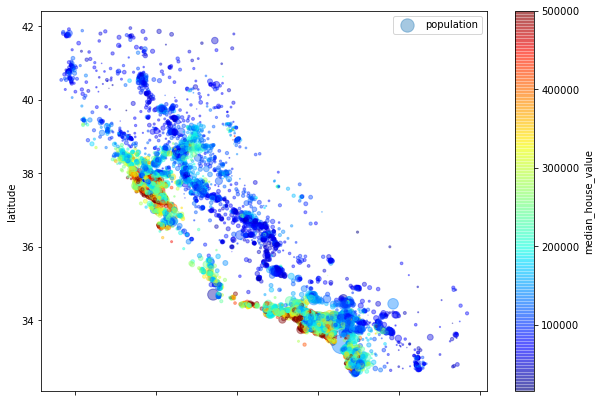

In [12]:
#
# Observe the relation between location and population density.
# Based on good location (e.g. close to the ocean) and population density, the housing price tends to be higher.
#

import matplotlib.pyplot as plt

housing.plot(kind="scatter", x="longitude", y="latitude", alpha=0.4,
             s=housing["population"]/100, label="population", figsize=(10, 7),
             c="median_house_value", cmap=plt.get_cmap("jet"), colorbar=True,
            )
plt.legend()

In [13]:
#
# Calculate Pearson's r
# Observe which attributes correlate the most with `median_house_value`
#

corr_matrix = housing.corr()
corr_matrix["median_house_value"].sort_values(ascending=False)

median_house_value    1.000000
median_income         0.687160
total_rooms           0.135097
housing_median_age    0.114110
households            0.064506
total_bedrooms        0.047689
population           -0.026920
longitude            -0.047432
latitude             -0.142724
Name: median_house_value, dtype: float64

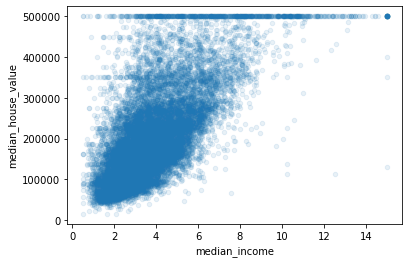

In [14]:
#
# Observe the correlation between `median_income` and `median_house_value`
#

from pandas.plotting import scatter_matrix

housing.plot(kind="scatter", x="median_income",y="median_house_value",alpha=0.1)

In [15]:
#
# When inspecting correlation with newly created attributes,
# we can see that houses with lower bedroom/room ration tend to be more expensive.
# Also the more `rooms_per_bedroom` (the bigger the house is), the more expensive it is.
#

housing["rooms_per_household"] = housing["total_rooms"]/housing["households"]
housing["bedrooms_per_room"] = housing["total_bedrooms"]/housing["total_rooms"]
housing["population_per_household"] = housing["population"]/housing["households"]

corr_matrix = housing.corr()
corr_matrix["median_house_value"].sort_values(ascending=False)

median_house_value          1.000000
median_income               0.687160
rooms_per_household         0.146285
total_rooms                 0.135097
housing_median_age          0.114110
households                  0.064506
total_bedrooms              0.047689
population_per_household   -0.021985
population                 -0.026920
longitude                  -0.047432
latitude                   -0.142724
bedrooms_per_room          -0.259984
Name: median_house_value, dtype: float64

## Preparing the data for Machine Learning Algorithm ##

### Handling numeric attributes ###

In [16]:
#
# Revert to a training dataset
#

housing = strat_train_set.drop("median_house_value", axis=1) # separating the predictors & labels
housing_labels = strat_train_set["median_house_value"].copy()

In [17]:
#
# Fill in missing values with median value for each numerical attribute
#

from sklearn.impute import SimpleImputer 

imputer = SimpleImputer(strategy="median")

housing_num_values = housing.drop("ocean_proximity", axis=1) # remove non-numerical values

imputer.fit(housing_num_values)

X = imputer.transform(housing_num_values)
housing_tr = pd.DataFrame(X, columns=housing_num_values.columns)


### Handling text and categorical attributes ###

In [18]:
housing_cat = housing["ocean_proximity"]

# housing_cat_encoded now contains purely numerical (factorized) values
housing_cat_encoded, housing_categories = housing_cat.factorize()

In [19]:
#
# One hot encode the categories (because now we assume that two nearby values are more similar to each other).
# Which is not the case - e.g. categories 0 and 4 are more similar then 0 and 2
#

from sklearn.preprocessing import OneHotEncoder

encoder = OneHotEncoder()

housing_cat_1hot = encoder.fit_transform(housing_cat_encoded.reshape(-1,1))
housing_cat_1hot # sparse matrix (only store location of non-zero elements)

<16512x5 sparse matrix of type '<class 'numpy.float64'>'
	with 16512 stored elements in Compressed Sparse Row format>

### Custom Transformers ###

In [20]:
#
# Custom attributes adder
#
from sklearn.base import BaseEstimator, TransformerMixin

rooms_ix, bedrooms_ix, population_ix, household_ix = 3, 4, 5, 6

class CombinedAttributesAdder(BaseEstimator, TransformerMixin):
    def __init__(self, add_bedrooms_per_room = True): # no *args or **kargs
        self.add_bedrooms_per_room = add_bedrooms_per_room
    def fit(self, X, y=None):
        return self
    def transform(self, X, y=None):
        rooms_per_household = X[:, rooms_ix] / X[:, household_ix]
        population_per_household = X[:, population_ix] / X[:, household_ix]
        if self.add_bedrooms_per_room:
            bedrooms_per_room = X[:, bedrooms_ix] / X[:, rooms_ix]
            return np.c_[X, rooms_per_household, population_per_household, bedrooms_per_room]
        else:
            return np.c_[X, rooms_per_household, population_per_household]

In [21]:
#
# Convert selected attributes (dropping the rest) DataFrame to NumPy array
#

from sklearn.base import BaseEstimator, TransformerMixin

class DataFrameSelector(BaseEstimator, TransformerMixin):
    def __init__(self, attribute_names):
        self.attribute_names = attribute_names
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        return X[self.attribute_names].values

## Feature Scaling ##

In [22]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

# numerical attributes transformation pipeline
num_attribs = list(housing_num_values)

num_pipeline = Pipeline([
    ('selector', DataFrameSelector(num_attribs)),
    ('imputer', SimpleImputer(strategy="median")),
    ('attribs_adder', CombinedAttributesAdder()),
    ('std_scaler', StandardScaler()),
])

# cat pipeline
cat_attribs = ["ocean_proximity"]

# full pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer

full_pipeline = ColumnTransformer([
        ("num", num_pipeline, num_attribs),
        ("cat", OneHotEncoder(), cat_attribs),
    ])

### Running the whole pipeline ###

In [23]:
housing_prepared = full_pipeline.fit_transform(housing)
housing_prepared

array([[-1.15604281,  0.77194962,  0.74333089, ...,  0.        ,
         0.        ,  0.        ],
       [-1.17602483,  0.6596948 , -1.1653172 , ...,  0.        ,
         0.        ,  0.        ],
       [ 1.18684903, -1.34218285,  0.18664186, ...,  0.        ,
         0.        ,  1.        ],
       ...,
       [ 1.58648943, -0.72478134, -1.56295222, ...,  0.        ,
         0.        ,  0.        ],
       [ 0.78221312, -0.85106801,  0.18664186, ...,  0.        ,
         0.        ,  0.        ],
       [-1.43579109,  0.99645926,  1.85670895, ...,  0.        ,
         1.        ,  0.        ]])

## Select and Train a model ##

### Linear regression ###


Text(0.5, 1.0, 'Linear regression predictions vs labels')

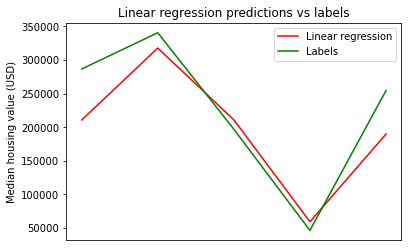

In [52]:
from sklearn.linear_model import LinearRegression

lin_reg = LinearRegression()
lin_reg.fit(housing_prepared, housing_labels)

some_data = housing.iloc[:5]
some_labels = housing_labels.iloc[:5]
some_data_prepared = full_pipeline.transform(some_data)

plt.plot(lin_reg.predict(some_data_prepared), c="red")
plt.plot(list(some_labels), c="green")
plt.legend(["Linear regression", "Labels"])
plt.xticks([])
plt.ylabel("Median housing value (USD)")
plt.title("Linear regression predictions vs labels")

The predictions are not exactly accurate (e.g. the first predictions is off by close to 40%). Let's measure RMSE on the whole training set

In [47]:
from sklearn.metrics import mean_squared_error

housing_predictions = lin_reg.predict(housing_prepared)
lin_mse = mean_squared_error(housing_labels, housing_predictions)
lin_rmse = np.sqrt(lin_mse)
lin_rmse

68628.19819848923

As we can see, the prediction error is about **68,628 USD**. That is not very satisfying, given that median_housing_values range between 120,000 USD and 265,000 USD. This is an example of **model underfitting**. Lets try more powerful model.

### Decision Tree Regression ###

In [56]:
from sklearn.tree import DecisionTreeRegressor

tree_reg = DecisionTreeRegressor()
tree_reg.fit(housing_prepared, housing_labels)

housing_predictions = tree_reg.predict(housing_prepared)
tree_mse = mean_squared_error(housing_labels, housing_predictions)
tree_rmse = np.sqrt(tree_mse)
tree_rmse

0.0

### Evaluate using Cross-Validation ###

In [62]:
def display_scores(scores):
    print("Scores: ", scores)
    print("Mean: ", scores.mean())
    print("Standard deviation", scores.std())

In [63]:
from sklearn.model_selection import cross_val_score
scores = cross_val_score(tree_reg, housing_prepared, housing_labels, scoring="neg_mean_squared_error", cv=10)
tree_rmse_scores = np.sqrt(-scores)
    
display_scores(tree_rmse_scores)

Scores:  [68408.18229922 66181.62439858 71960.2609219  69564.73754912
 71266.50374778 76208.70921958 70680.76899376 71635.06864831
 77122.27557578 69773.90531505]
Mean:  71280.20366690806
Standard deviation 3143.6231299150136


In [67]:
lin_scores = cross_val_score(lin_reg, housing_prepared, housing_labels, scoring="neg_mean_squared_error", cv=10)
lin_rmse_scores = np.sqrt(-lin_scores)
display_scores(lin_rmse_scores)

Scores:  [66782.73843989 66960.118071   70347.95244419 74739.57052552
 68031.13388938 71193.84183426 64969.63056405 68281.61137997
 71552.91566558 67665.10082067]
Mean:  69052.46136345083
Standard deviation 2731.674001798349


### Linear Regression vs Decision Tree Regression ###

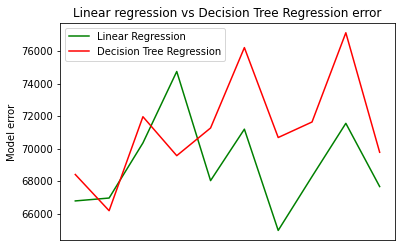

In [74]:
plt.plot(lin_rmse_scores, c="green")
plt.plot(tree_rmse_scores, c="red")
plt.xticks([])
plt.ylabel("Model error")
plt.title("Linear regression vs Decision Tree Regression error")
plt.legend(["Linear Regression", "Decision Tree Regression"])

The Decision Tree model is overfitting so badly, that it performs worse than the Linear Regression model.

### Random Forest Regression ###

In [78]:
from sklearn.ensemble import RandomForestRegressor

forest_reg = RandomForestRegressor()
forest_reg.fit(housing_prepared, housing_labels)

forest_scores = cross_val_score(forest_reg, housing_prepared, housing_labels, scoring="neg_mean_squared_error", cv=10)
forest_rmse_scores = np.sqrt(-forest_scores)
display_scores(forest_rmse_scores)

Scores:  [49671.30040772 47587.38607235 49813.5491003  52338.4914143
 49257.76190663 53580.40380375 48677.81489561 48222.29152552
 53079.96745663 50320.7514204 ]
Mean:  50254.97180032063
Standard deviation 1965.951675202141


### Model performance comparison ###

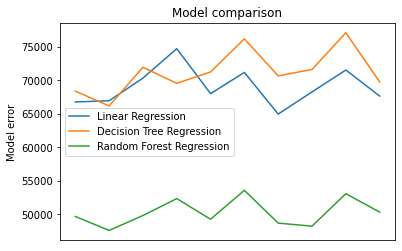

In [81]:
plt.plot(lin_rmse_scores)
plt.plot(tree_rmse_scores)
plt.plot(forest_rmse_scores)
plt.xticks([])
plt.ylabel("Model error")
plt.title("Model comparison")
plt.legend(["Linear Regression", "Decision Tree Regression", "Random Forest Regression"])

**Random Forest** looks very promising, with the least error of all the above models.

## Fine-Tuning the Model ##

### Grid Search ###

In [85]:
from sklearn.model_selection import GridSearchCV

params_grid = [
    {'n_estimators': [3, 10, 30], 'max_features': [2, 4, 6, 8]},
    {'bootstrap': [False], 'n_estimators': [3, 10], 'max_features': [2, 3, 4]},
]

forest_reg = RandomForestRegressor()
grid_search = GridSearchCV(forest_reg, params_grid, cv=5, scoring='neg_mean_squared_error')
grid_search.fit(housing_prepared, housing_labels)

GridSearchCV(cv=5, estimator=RandomForestRegressor(),
             param_grid=[{'max_features': [2, 4, 6, 8],
                          'n_estimators': [3, 10, 30]},
                         {'bootstrap': [False], 'max_features': [2, 3, 4],
                          'n_estimators': [3, 10]}],
             scoring='neg_mean_squared_error')

In [90]:
grid_search.best_estimator_

RandomForestRegressor(max_features=8, n_estimators=30)

## Feature importance ##

In [95]:
feature_importances = grid_search.best_estimator_.feature_importances_

extra_attribs = ["rooms_per_hhold", "pop_per_hhold", "bedrooms_per_room"]
cat_encoder = full_pipeline.named_transformers_["cat"]
cat_one_hot_attribs = list(cat_encoder.categories_[0])
attributes = num_attribs + extra_attribs + cat_one_hot_attribs

sorted(zip(feature_importances, attributes), reverse=True)

[(0.33357633626471667, 'median_income'),
 (0.1834932515306883, 'INLAND'),
 (0.11193580081889315, 'pop_per_hhold'),
 (0.07319226610853165, 'longitude'),
 (0.07058957051168163, 'bedrooms_per_room'),
 (0.06214343167631866, 'latitude'),
 (0.05505754521840238, 'rooms_per_hhold'),
 (0.04268450248611256, 'housing_median_age'),
 (0.01580781152109858, 'total_rooms'),
 (0.015370175636148342, 'population'),
 (0.013754856293102675, 'households'),
 (0.013529672231445727, 'total_bedrooms'),
 (0.004515475284800208, '<1H OCEAN'),
 (0.0025631872065933472, 'NEAR OCEAN'),
 (0.001704803576402955, 'NEAR BAY'),
 (8.131363506323944e-05, 'ISLAND')]

## Evaluating on the Test Set ##

In [102]:
final_model = grid_search.best_estimator_

X_test = strat_test_set.drop("median_house_value", axis=1)
y_test = strat_test_set["median_house_value"].copy()

X_test_prepared = full_pipeline.transform(X_test)

final_predictions = final_model.predict(X_test_prepared)

final_mse = mean_squared_error(y_test, final_predictions)
final_rmse = np.sqrt(final_mse)

final_rmse

48090.59115826513

## Conclusion ##

* **Median income** is the number one predictor for housing prices
* Final **RMSE** for the Random Forest model on the test set is about 48,090 USD